In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\seoha\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [18]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\seoha\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [3]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

#read data and take a look
df = pd.read_csv('./data/imagePoses.csv')
df.head()

,imageName,base64encoded,imageWidth,imageHeight,poseLandmarks,excercise
0,full-body-person-doing-pushup0.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQERMT...,183,275,"['x: 0.7909860014915466,y: 0.2797396183013916,...",pushup
1,full-body-person-doing-pushup1.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgW...,244,206,"['x: 0.5600898265838623,y: 0.5534414052963257,...",pushup
2,full-body-person-doing-pushup10.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRUW...,167,302,"['x: 0.4751896560192108,y: 0.4453135132789612,...",pushup
3,full-body-person-doing-pushup100.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgW...,183,275,"['x: 0.4743218421936035,y: 0.5276893377304077,...",pushup
4,full-body-person-doing-pushup101.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIREhUT...,225,225,NaN,pushup


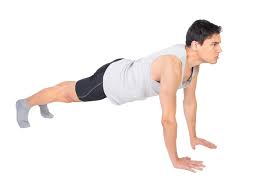

In [4]:
from base64 import b64decode
from IPython import display

#decode from base64
imgB64 = df['base64encoded'][0][2:]
imgStr = b64decode(imgB64)
display.Image(imgStr)

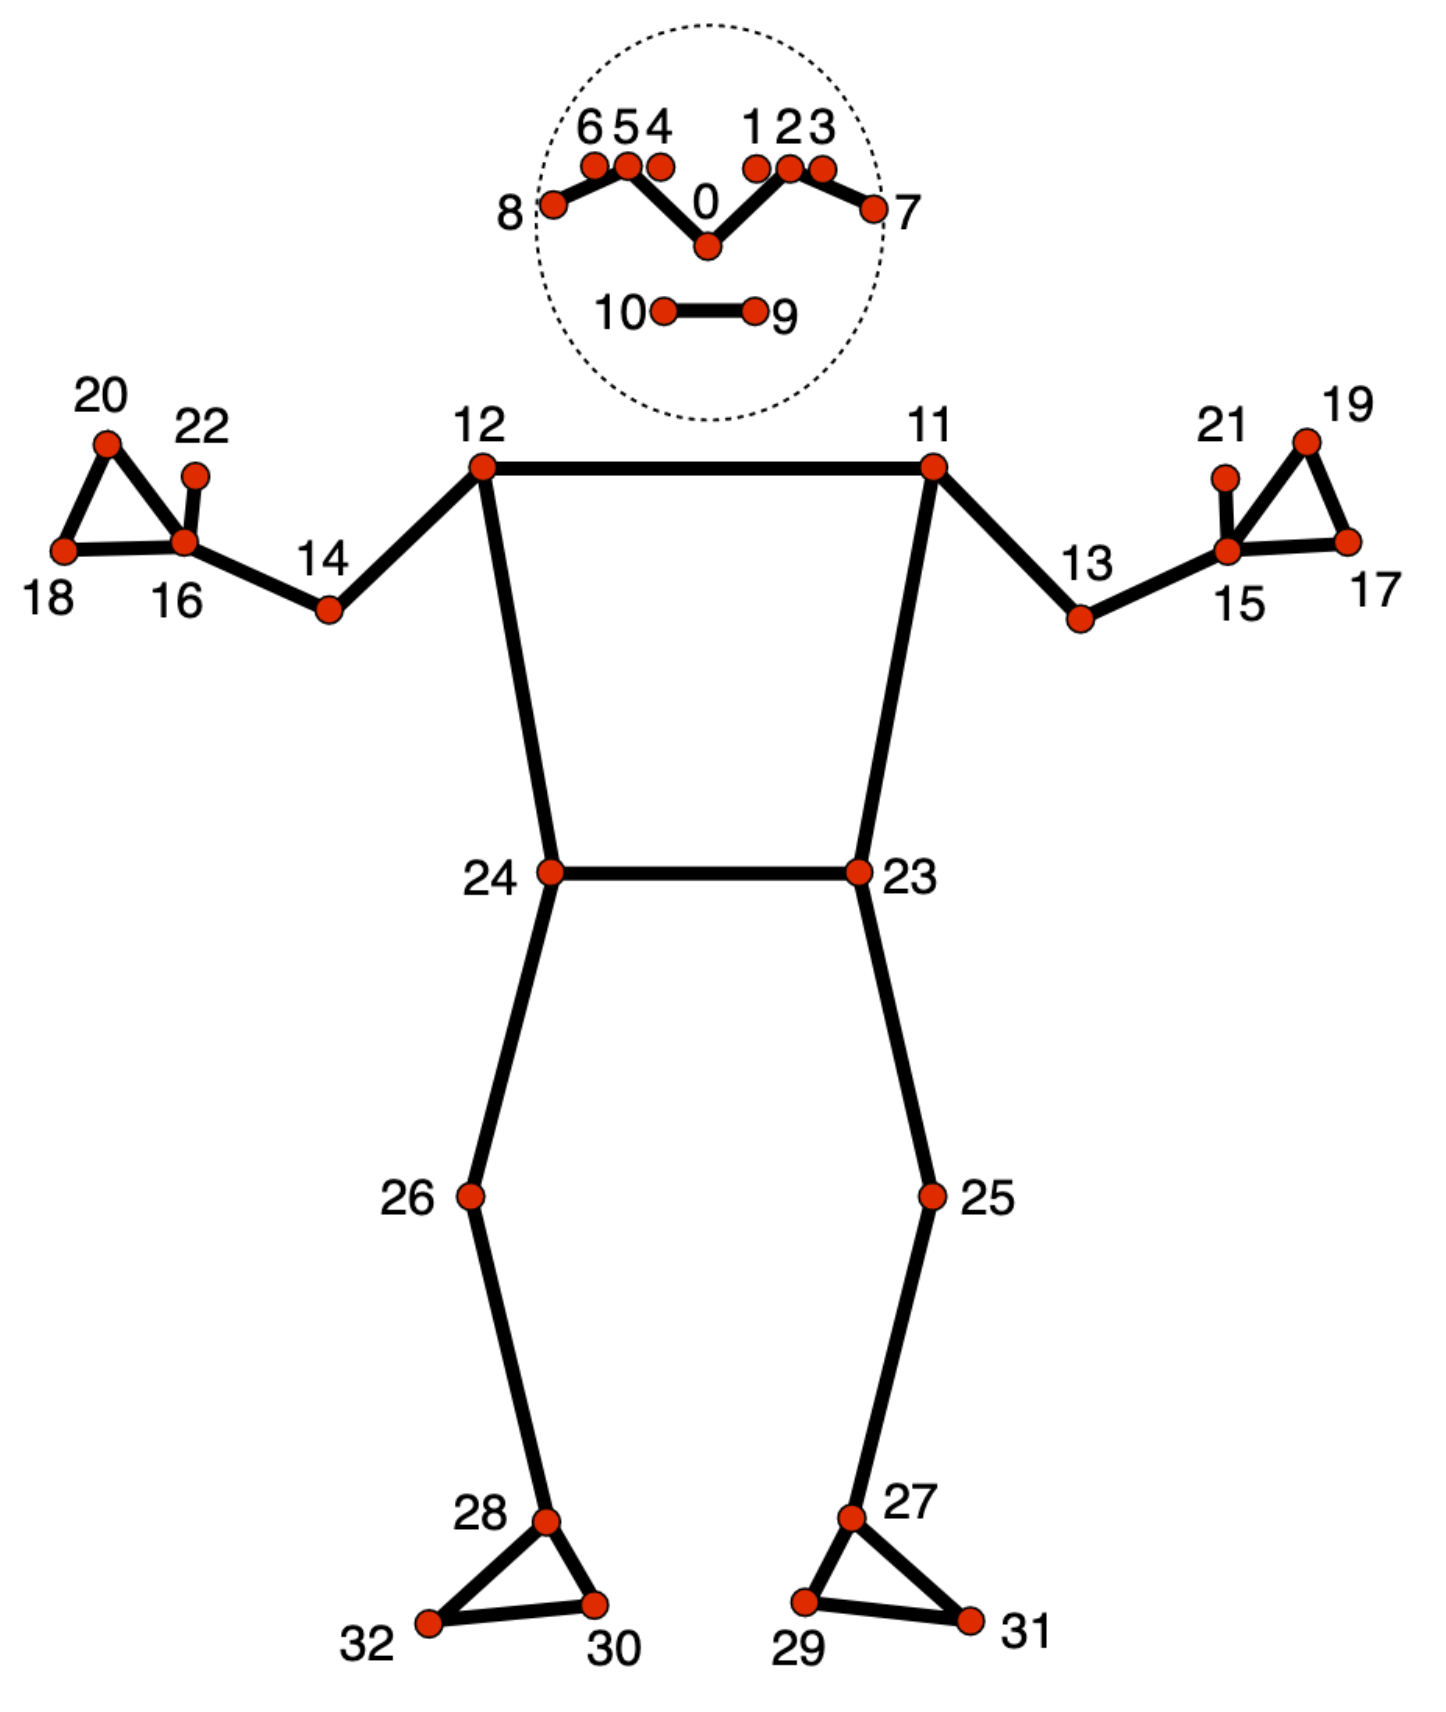

In [5]:
display.Image("https://developers.google.com/static/mediapipe/images/solutions/pose_landmarks_index.png")

In [6]:
#consts to ensure correct landmarks are chosen
LANDMARKS_PER_IMG = 33
FACE_LANDMARKS = 44 # 4 (i.e. x, y ,z, visibility) * 11 (i.e. num of face landmarks)

def cleanPLs(lm):
    """Cleans up the Pose Landmarks into useable format

    Parameters:
        lm (str): string of Pose Landmarks from CSV

    Returns:
        cleanLM (list): list of Pose Landmarks values seperated
    """
    
    a = lm.replace("'", '').replace('"', '').strip('][').split(',')
    while ('' in a):
        a.remove('')
    cleanLM = []
    for i in range(FACE_LANDMARKS, len(a) - 3, 4):
        a[i] = a[i].strip()
        cleanLM.append([a[i], a[i+1], a[i+2], a[i+3]])
    return cleanLM

cleanLandmarks = cleanPLs(df['poseLandmarks'][0])
cleanLandmarks[:5]

[['x: 0.6967951059341431',
  'y: 0.3416728675365448',
  'z: -0.24294953048229218',
  'visibility: 0.9974461793899536'],
 ['x: 0.6145135760307312',
  'y: 0.4006616175174713',
  'z: -0.8616045713424683',
  'visibility: 0.9999167919158936'],
 ['x: 0.6923354864120483',
  'y: 0.5666109919548035',
  'z: -0.06122667342424393',
  'visibility: 0.42084839940071106'],
 ['x: 0.6081704497337341',
  'y: 0.6399567723274231',
  'z: -0.9428333640098572',
  'visibility: 0.9989722967147827'],
 ['x: 0.7111308574676514',
  'y: 0.7498202919960022',
  'z: -0.15003161132335663',
  'visibility: 0.6430759429931641']]

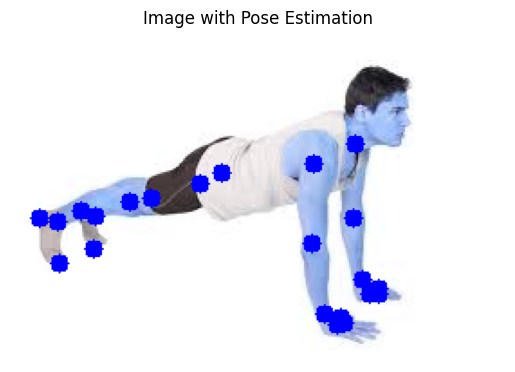

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

#convert from bytestring to cv image
nparr = np.fromstring(imgStr, np.uint8)
imgPose = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

#loop thru landmarks
for lm in cleanLandmarks:
    h, w, c = imgPose.shape
    #strip digits and convert to x, y floats
    x = float(lm[0].replace('x: ', ''))
    y = float(lm[1].replace('y: ', ''))
    #multiply and create shapes on image
    cx, cy = int(x*w), int(y*h)
    cv2.circle(imgPose, (cx, cy), 5, (0,0,255), cv2.FILLED)

plt.imshow(imgPose)
plt.title('Image with Pose Estimation')
plt.axis('off')
plt.show()

In [8]:
#look at how many nulls there are
df.isna().sum()

imageName          0
base64encoded      0
imageWidth         0
imageHeight        0
poseLandmarks    860
excercise          0
dtype: int64

In [9]:
#drop nullities
df = df.dropna()

In [10]:
df.isna().sum()

imageName        0
base64encoded    0
imageWidth       0
imageHeight      0
poseLandmarks    0
excercise        0
dtype: int64

In [11]:
#have a look at the number of different exercises
df['excercise'].value_counts()

lunges            333
squat             330
plank             320
pullup            315
pushup            309
shoulder press    286
chest dips        272
bent over row     246
glute bridge      230
Name: excercise, dtype: int64

In [12]:
#clean all pose landmarks
df['poseLandmarks'] = df['poseLandmarks'].apply(lambda x : cleanPLs(x))

In [13]:
#create new column of only float values
def poseToFloats(lm):
    """Strips the string to extract float values

    Parameters:
        lm (list): list of strings of Pose Landmark values

    Returns:
        res (list): list of float values of Pose Landmarks
    """

    res = []
    for i in lm:
        x = float(i[0].replace('x: ', ''))
        y = float(i[1].replace('y: ', ''))
        z = float(i[2].replace('z: ', ''))
        v = float(i[3].replace('visibility: ', ''))
        res.append(x)
        res.append(y)
        res.append(z)
        res.append(v)
    return res
    
#add new column
df['poseAsFloats'] = df['poseLandmarks'].apply(lambda x : poseToFloats(x))
df['poseAsFloats'].head()

0    [0.6967951059341431, 0.3416728675365448, -0.24...
1    [0.5371230244636536, 0.4670667350292206, -0.11...
2    [0.5360893607139587, 0.44331541657447815, -0.2...
3    [0.4350466728210449, 0.35678616166114807, -0.1...
5    [0.6990968585014343, 0.45882853865623474, -0.1...
Name: poseAsFloats, dtype: object

In [14]:
#function to encode target
def exerciseToInt(x):
    """Encodes the exercise label into an integer

    Parameter:
        x (str): exercise label
    
    Returns:
        x (int): encoded int for classifier
    """

    if x == 'pushup':
        x = 0
    elif x == 'bent over row':
        x = 1
    elif x == 'chest dips':
        x = 2
    elif x == 'glute bridge':
        x = 3
    elif x == 'lunges':
        x = 4
    elif x == 'plank':
        x = 5
    elif x == 'pullup':
        x = 6
    elif x == 'shoulder press':
        x = 7
    elif x == 'squat':
        x = 8
    return x

In [15]:
#FACE_LANDMARKS is divided by 4 b/c...
#...each landmark has 4 values (x, y, z, visibility)
LANDMARKS_RANGE = int(LANDMARKS_PER_IMG - (FACE_LANDMARKS / 4))
#create columns for poses data
col = []
for i in range(LANDMARKS_RANGE):
    col.append('x_data' + str(i))
    col.append('y_data' + str(i))
    col.append('z_data' + str(i))
    col.append('v_data' + str(i))

df_enc = pd.DataFrame(df['poseAsFloats'].to_list(), columns=col)

#feature
feature = df_enc
#target
target = df['excercise'].apply(lambda x : exerciseToInt(x))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=1)
# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training target:', y_train.shape)
print('Shape of testing target:', y_test.shape)

Shape of training feature: (2112, 88)
Shape of testing feature: (529, 88)
Shape of training target: (2112,)
Shape of testing target: (529,)


In [20]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average='micro')
    rec = metrics.recall_score(y_test, y_pred, average='micro')
    f1 = metrics.f1_score(y_test, y_pred, average='micro')
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'cm': cm}

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [23]:

rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.776937618147448
Precision: 0.776937618147448
Recall: 0.776937618147448
F1 Score: 0.776937618147448
Cohens Kappa Score: 0.7487107851228025
Confusion Matrix:
 [[53  0  1  0  0  3  0  0  0]
 [ 0 43  6  0  0  1  0  0  1]
 [ 0  3 47  0  1  0  0  0  0]
 [ 1  1  2 34  6  4  0  0  3]
 [ 0  0  0  4 37  4  0  0 13]
 [ 1  2  0  6  0 56  0  1  0]
 [ 0  0  3  0  0  0 51  8  0]
 [ 0  1  1  0  0  0 12 42  2]
 [ 2  4  4  0 13  0  2  2 48]]


In [24]:
from joblib import dump
# Saving model
dump(rf, 'exerciseImageClassifier.joblib')

['exerciseImageClassifier.joblib']